# Import Libraries

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

warnings.filterwarnings('ignore')

%matplotlib inline

# Set seed for reproducibility

In [15]:
# Set seed for reproducibility
import random
import numpy as np
import tensorflow as tf

SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Load Dataset, Define Features, and Split the Data

In [16]:
# Load dataset
df = pd.read_csv('recruitment_data.csv')

# Define the features and the target class
x = df.drop(columns=['HiringDecision'], axis=1)
y = df['HiringDecision']

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

# Perform feature selection

Number of features: 1
Selected features: ['RecruitmentStrategy']
Test Accuracy: 83.33%

Number of features: 2
Selected features: ['EducationLevel', 'RecruitmentStrategy']
Test Accuracy: 83.33%

Number of features: 3
Selected features: ['EducationLevel', 'SkillScore', 'RecruitmentStrategy']
Test Accuracy: 82.89%

Number of features: 4
Selected features: ['EducationLevel', 'SkillScore', 'PersonalityScore', 'RecruitmentStrategy']
Test Accuracy: 83.11%

Number of features: 5
Selected features: ['EducationLevel', 'ExperienceYears', 'SkillScore', 'PersonalityScore', 'RecruitmentStrategy']
Test Accuracy: 79.56%

Number of features: 6
Selected features: ['EducationLevel', 'ExperienceYears', 'InterviewScore', 'SkillScore', 'PersonalityScore', 'RecruitmentStrategy']
Test Accuracy: 83.33%

Number of features: 7
Selected features: ['EducationLevel', 'ExperienceYears', 'PreviousCompanies', 'InterviewScore', 'SkillScore', 'PersonalityScore', 'RecruitmentStrategy']
Test Accuracy: 83.33%

Number of fe

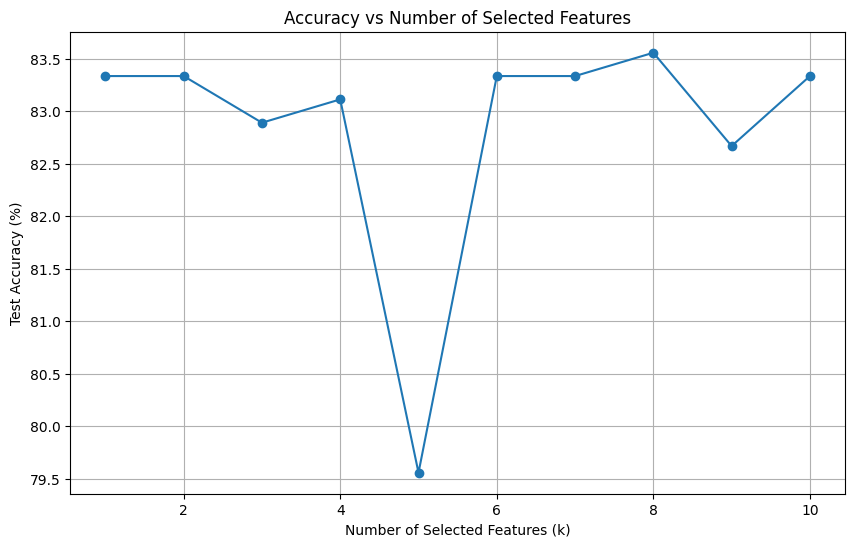

In [17]:
# Feature Selection
k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
accuracies = []

for k in k_values:
    selector = SelectKBest(score_func=f_classif, k=k)
    x_train_selected = selector.fit_transform(x_train, y_train)
    x_test_selected = selector.transform(x_test)

    # Get the selected feature names
    selected_features = x.columns[selector.get_support()].tolist()

    # Apply SMOTE to the training set
    smote = SMOTE(random_state=123)
    x_train_resampled, y_train_resampled = smote.fit_resample(x_train_selected, y_train)

    # Define SVM with fixed parameters
    svm = SVC(kernel='linear', gamma=10000, C=10, probability=True)
    svm.fit(x_train_resampled, y_train_resampled)

    # Evaluate the model
    y_pred_test = svm.predict(x_test_selected)
    test_accuracy = accuracy_score(y_test, y_pred_test) * 100

    print(f"Number of features: {k}")
    print(f"Selected features: {selected_features}")
    print(f"Test Accuracy: {test_accuracy:.2f}%\n")

    accuracies.append(test_accuracy)

# Plotting accuracy vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('Accuracy vs Number of Selected Features')
plt.xlabel('Number of Selected Features (k)')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.show()

# Evaluate the Best Model and Plot the ROC Curve

Best k value: 8
Selected features: ['EducationLevel', 'ExperienceYears', 'PreviousCompanies', 'DistanceFromCompany', 'InterviewScore', 'SkillScore', 'PersonalityScore', 'RecruitmentStrategy']
* Training score: 83.333
* Testing score: 83.556

Accuracy:  83.55555555555556
Recall:  83.55555555555556
Precision:  85.23183989280079
F1-Score:  84.00898692810458


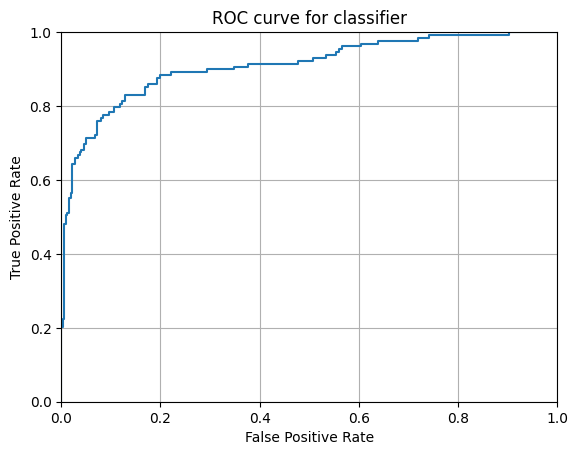

AUC Score: 0.9096331715327586


In [18]:
# Select the best k value based on the highest accuracy
best_k = k_values[accuracies.index(max(accuracies))]
selector = SelectKBest(score_func=f_classif, k=best_k)
x_train_selected = selector.fit_transform(x_train, y_train)
x_test_selected = selector.transform(x_test)

# Get the selected feature names
selected_features = x.columns[selector.get_support()].tolist()
print(f"Best k value: {best_k}")
print(f"Selected features: {selected_features}")

# Apply SMOTE to the training set
smote = SMOTE(random_state=123)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_selected, y_train)

# Define SVM with fixed parameters
svm = SVC(kernel='linear', gamma=10000, C=10, probability=True)
svm.fit(x_train_resampled, y_train_resampled)

# Evaluate the best model
print('* Training score: %.3f' % (svm.score(x_train_resampled, y_train_resampled) * 100))
print('* Testing score: %.3f' % (svm.score(x_test_selected, y_test) * 100))
print()

y_pred = svm.predict(x_test_selected)
print('Accuracy: ', accuracy_score(y_test, y_pred) * 100)
print('Recall: ', recall_score(y_test, y_pred, average='weighted') * 100)
print('Precision: ', precision_score(y_test, y_pred, average='weighted') * 100)
print('F1-Score: ', f1_score(y_test, y_pred, average='weighted') * 100)

# Compute ROC curve and AUC score
y_pred_prob = svm.predict_proba(x_test_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

print("AUC Score:", roc_auc_score(y_test, y_pred_prob))

# Plot Confusion Matrix

<Figure size 800x600 with 0 Axes>

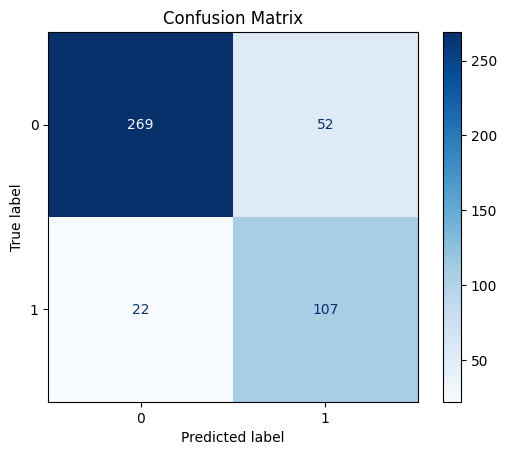

In [19]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=svm.classes_)
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [24]:
import joblib

model_filename = 'svm_model_over_fs.joblib'
joblib.dump({'model': svm, 'best_k': best_k}, model_filename)

['svm_model_over_fs.joblib']

In [20]:
import winsound
winsound.MessageBeep()